# Загрузка необходимых библиотек

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import zipfile
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# прописываем путь к архиву
zip_file = '/content/drive/MyDrive/DS_identity_emotions/input_data/redact_clean.zip'

# распакуем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [4]:
# определим папки с данными, теперь итоговые изображения находятся в папке redact
train_dir = Path().parent / "redact"

train_anger_dir = train_dir / 'anger'
train_contempt_dir = train_dir / 'contempt'
train_disgust_dir = train_dir / 'disgust'
train_fear_dir = train_dir / 'fear'
train_happy_dir = train_dir / 'happy'
train_neutral_dir = train_dir / 'neutral'
train_sad_dir = train_dir / 'sad'
train_surprise_dir = train_dir / 'surprise'
train_uncertain_dir = train_dir / 'uncertain'

In [5]:
def show_catsdogs(images, labels, predicted_labels=None, row=False, title=""):
    '''Функция для отображения изображений'''
    names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear", 4: "happy", 
             5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}
    fig = plt.figure(figsize=(10, 3 if row else 10))
    st = fig.suptitle(title, fontsize="x-large")
    n = 5 if row else 16
    for i in range(n):
        if not row:
            plt.subplot(4,4, i+1)
        else:
            plt.subplot(1,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[np.argmax(labels[i])]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[np.argmax(labels[i])]}")

#VGG 19

In [7]:
from tensorflow.keras.applications.vgg19 import preprocess_input
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Подготовка входных данных

In [8]:
BATCH_SIZE = 128

In [9]:
image_gen_no_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)
sample_no_aug = image_gen_no_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(128,128),
                                                     class_mode='categorical',
                                                     subset = "training",
                                                     seed=123
                                                     )

Found 38569 images belonging to 9 classes.


In [10]:
# а теперь мы попросим его изменять изображение на лету, добавляя небольшие повороты + отражения по горизонтали
image_gen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # максимальный угол поворота
    horizontal_flip=True, # случайное отражение по горизонтали
    fill_mode="nearest", # чем заполнять пробелы
    validation_split=0.2  # соотношение тренировочных/валидационных данных = 0.8/0.2
    ) 



train_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=train_dir,
                                                   shuffle=True,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   subset = "training",
                                                   seed = 123)  # 80%

val_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=train_dir,
                                                 shuffle=False,
                                                 target_size=(128,128),
                                                 class_mode='categorical',
                                                 subset = "validation",
                                                 seed = 123)  # 20%


Found 38569 images belonging to 9 classes.
Found 9639 images belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


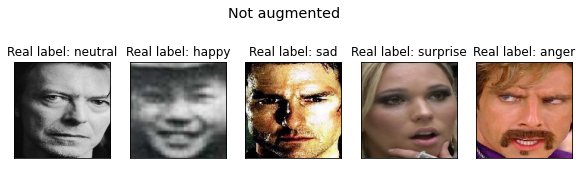

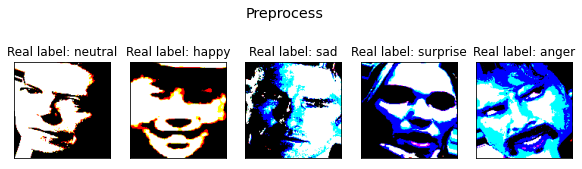

In [11]:
sample_images, sample_labels = next(sample_no_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Not augmented")
sample_images, sample_labels = next(train_data_gen)
show_catsdogs(sample_images, sample_labels, row=True, title="Preprocess")

##Загрузка архитектуры модели, инициализируем веса обученные на датасете ImageNet

In [ ]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- VGG19
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')
base_model.trainable = False # замораживаем всю базовую модель

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

Попробуем сначала взять архитектуру исходную, не изменяя веса. В конце сети добавим Dense слой на 9 нейронов - кол-во классов, обучим его и посмотрим графически точность на валидационной и тестовой выборке.

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')  # 9 - кол-во классов
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 9)                 4617      
                                                                 
Total params: 20,029,001
Trainable params: 4,617
Non-trainable params: 20,024,384
_________________________________________________________________


###Замерим время инференса

In [ ]:
sample_images, sample_labels = next(val_data_gen)
test_img = sample_images[0][None,...]
test_img.shape

(1, 128, 128, 3)

In [ ]:
%%time

predictions = model.predict(test_img)

CPU times: user 50.8 ms, sys: 3.92 ms, total: 54.7 ms
Wall time: 63.8 ms


In [ ]:
%%timeit -n 10 -r 10

predictions = model.predict(test_img)

10 loops, best of 10: 44.6 ms per loop


##Время инференса удовлетворяет условию задачи, дальше приступим к обучению модели и тестированию

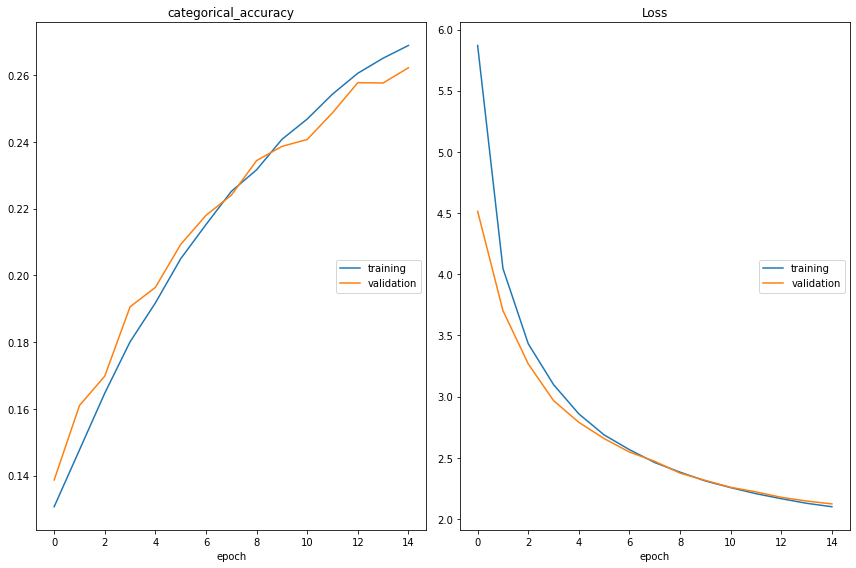

categorical_accuracy
	training         	 (min:    0.131, max:    0.269, cur:    0.269)
	validation       	 (min:    0.139, max:    0.262, cur:    0.262)
Loss
	training         	 (min:    2.099, max:    5.870, cur:    2.099)
	validation       	 (min:    2.122, max:    4.514, cur:    2.122)
302/302 [==============================] - 429s 1s/step - loss: 2.0992 - categorical_accuracy: 0.2688 - val_loss: 2.1223 - val_categorical_accuracy: 0.2622


In [ ]:
EPOCHS = 15
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [ ]:
model.save('./model_vgg19/1')

In [ ]:
model.save('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_one_dense')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/vgg19_one_dense/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/vgg19_one_dense/assets


In [ ]:
!zip -r model_vgg19.zip model_vgg19

Разморозим все веса и обучим всю архитектуру.

In [12]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- vgg19
all_base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
all_base_model.trainable = True # размораживаем всю базовую модель

80150528/80134624 [==============================] - 0s 0us/step


In [13]:
model_all = tf.keras.Sequential([
  all_base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')  # 9 - кол-во классов
])

model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

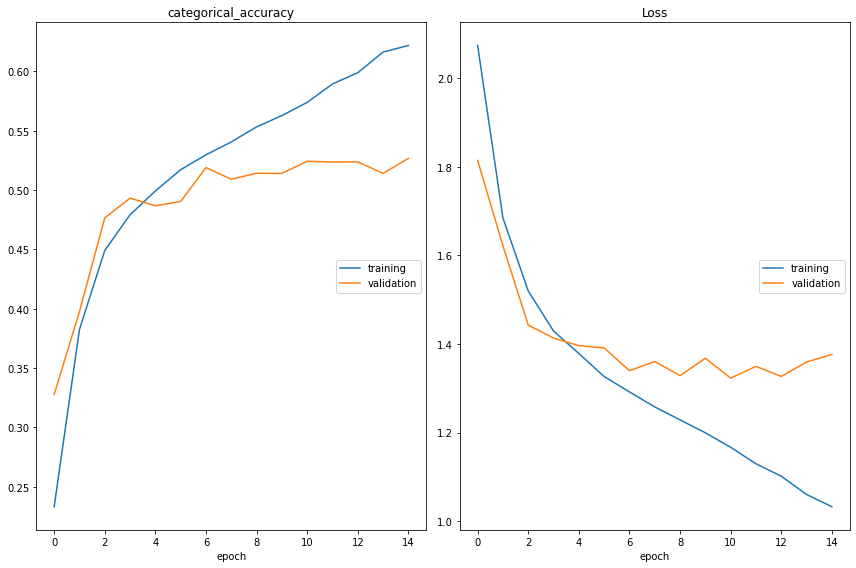

categorical_accuracy
	training         	 (min:    0.233, max:    0.622, cur:    0.622)
	validation       	 (min:    0.328, max:    0.527, cur:    0.527)
Loss
	training         	 (min:    1.033, max:    2.074, cur:    1.033)
	validation       	 (min:    1.323, max:    1.815, cur:    1.376)
302/302 [==============================] - 462s 2s/step - loss: 1.0327 - categorical_accuracy: 0.6219 - val_loss: 1.3763 - val_categorical_accuracy: 0.5267


In [14]:
EPOCHS = 15
history_all = model_all.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [15]:
model_all.save('./model_vgg19_all/1')

INFO:tensorflow:Assets written to: ./model_vgg19_all/1/assets


In [16]:
!zip -r model_vgg19_all.zip model_vgg19_all

  adding: model_vgg19_all/ (stored 0%)
  adding: model_vgg19_all/1/ (stored 0%)
  adding: model_vgg19_all/1/saved_model.pb (deflated 91%)
  adding: model_vgg19_all/1/assets/ (stored 0%)
  adding: model_vgg19_all/1/keras_metadata.pb (deflated 96%)
  adding: model_vgg19_all/1/variables/ (stored 0%)
  adding: model_vgg19_all/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_vgg19_all/1/variables/variables.index (deflated 75%)


In [17]:
model_all.save('/content/drive/MyDrive/DS_identity_emotions/model/vgg19_all')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/vgg19_all/assets


In [ ]:
output_weights = Path("/content/drive/My Drive/weights_VGG19")
output_weights.mkdir(exist_ok=True, parents=True)
assert output_weights.exists()
file_name_weights = 'weights_VGG19.hdf5'
cpt_path_weights = str(output_weights / file_name_weights)

model_all.save_weights(cpt_path_weights, save_format='hdf5')

#Вывод:</br>
Аналогично процессу обучения MobileNetV2:</br>*Использовались изображения обрезанные по Bounding box.</br>
С целью расширения вариативности входных данных - была проведена аугментация. Увеличивать, уменьшать и сдвигать изображения - не имеет смысла, т.к. они обрезаны по границе лица. В качестве вариации было задано: поворот - не более чем на 20 градусов и отражение по горизонтали.*</br></br>
Модель: **VGG19** показала лучше результаты, чем **MobileNetV2**, если обучать все веса модели.</br>
Максимально достигнутая точность на валидационных данных: 0.527.</br>
Среднее время инференса: 44.6 мс.